In [1]:
import pandas as pd

In [2]:
test = pd.read_csv("../data/processed/test_detrended.csv")
train = pd.read_csv("../data/processed/train_detrended.csv")
seasonality_df = pd.read_csv("../data/processed/seasonality_components.csv")

# Standardization

In [7]:
#standardize target values and features:
#features because: Standardizing the features is crucial for models like Lasso and Ridge regression because these models use regularization terms
#that depend on the scale of the coefficients: Features with larger scales (e.g., salary in thousands vs. age in years) will naturally have larger coefficients and
#the regularization penalty will disproportionately affect coefficients of features with larger scales-> so is a must to standardize
#target value not a must but helps prevent issues with numerical precision, especially for very large datasets or extreme target value ranges.

In [3]:
test.head()


,DATE,WATER_LEVEL,HUMIDITY,MEAN_TEMP,PRECIPITATION,PRESSURE,SNOW_DEPTH,SUNSHINE,WIND_SPEED,GLOBAL_RADIATION,...,MOON_ILLUMINATION,CLIMATE_CHANGE,WATER_LEVEL_LAG_1,WATER_LEVEL_LAG_2,WATER_LEVEL_LAG_3,WATER_LEVEL_LAG_4,WATER_LEVEL_LAG_5,WATER_LEVEL_LAG_6,WATER_LEVEL_LAG_7,LOG_WATER_LEVEL
0,2018-01-01,5.814955,54.966096,158.185998,25.503455,10126.490282,0.343520,101.963267,51.218443,160.392824,...,93.24608,0.261758,5.813526,5.812020,5.815046,5.817408,5.820889,5.827840,5.837170,5.823046
1,2018-01-02,5.834879,61.616171,126.354992,27.376329,10084.646488,0.358823,84.066813,50.943048,157.222570,...,98.02259,0.261758,5.836918,5.834440,5.835472,5.839615,5.843447,5.848409,5.856328,5.823046
2,2018-01-03,5.838346,62.614585,125.849908,42.411914,10081.639138,-0.564266,78.011627,50.787032,166.943577,...,99.91610,0.261758,5.837851,5.836957,5.834469,5.835498,5.839636,5.843466,5.848431,5.823046
3,2018-01-04,5.853000,69.275557,142.172221,92.154747,9992.490891,-1.038637,43.056889,56.794486,128.933991,...,98.74032,0.261758,5.841307,5.837891,5.836987,5.834496,5.835521,5.839657,5.843489,5.834811
4,2018-01-05,5.885116,77.101825,138.843850,136.285037,9982.019579,-0.730957,57.625725,57.127055,137.166870,...,94.64586,0.261758,5.855919,5.841348,5.837921,5.837015,5.834520,5.835542,5.839681,5.872118


In [4]:
#split into test and train seasonality:
train_seasonality = seasonality_df[seasonality_df['dataset'] == 'train']
test_seasonality = seasonality_df[seasonality_df['dataset'] == 'test']

train_seasonality.head()
test_seasonality.head()

,date,dataset,column,seasonal_value
16436,2018-01-01,test,WATER_LEVEL,0.008091
16437,2018-01-02,test,WATER_LEVEL,-0.011834
16438,2018-01-03,test,WATER_LEVEL,-0.015300
16439,2018-01-04,test,WATER_LEVEL,-0.018189
16440,2018-01-05,test,WATER_LEVEL,-0.012998


In [5]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [6]:
tscv = TimeSeriesSplit(n_splits=5)

In [7]:
X_train = train.drop(columns=['WATER_LEVEL', 'DATE'])
y_train = train['WATER_LEVEL']

X_test = test.drop(columns=['WATER_LEVEL', 'DATE'])
y_test = test['WATER_LEVEL']



In [8]:
X_test

,HUMIDITY,MEAN_TEMP,PRECIPITATION,PRESSURE,SNOW_DEPTH,SUNSHINE,WIND_SPEED,GLOBAL_RADIATION,GROUNDWATER_LEVEL,MOON_ILLUMINATION,CLIMATE_CHANGE,WATER_LEVEL_LAG_1,WATER_LEVEL_LAG_2,WATER_LEVEL_LAG_3,WATER_LEVEL_LAG_4,WATER_LEVEL_LAG_5,WATER_LEVEL_LAG_6,WATER_LEVEL_LAG_7,LOG_WATER_LEVEL
0,54.966096,158.185998,25.503455,10126.490282,0.343520,101.963267,51.218443,160.392824,413.694378,93.24608,0.261758,5.813526,5.812020,5.815046,5.817408,5.820889,5.827840,5.837170,5.823046
1,61.616171,126.354992,27.376329,10084.646488,0.358823,84.066813,50.943048,157.222570,413.712533,98.02259,0.261758,5.836918,5.834440,5.835472,5.839615,5.843447,5.848409,5.856328,5.823046
2,62.614585,125.849908,42.411914,10081.639138,-0.564266,78.011627,50.787032,166.943577,413.712858,99.91610,0.261758,5.837851,5.836957,5.834469,5.835498,5.839636,5.843466,5.848431,5.823046
3,69.275557,142.172221,92.154747,9992.490891,-1.038637,43.056889,56.794486,128.933991,413.710742,98.74032,0.261758,5.841307,5.837891,5.836987,5.834496,5.835521,5.839657,5.843489,5.834811
4,77.101825,138.843850,136.285037,9982.019579,-0.730957,57.625725,57.127055,137.166870,413.692350,94.64586,0.261758,5.855919,5.841348,5.837921,5.837015,5.834520,5.835542,5.839681,5.872118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,64.928534,137.364182,23.872765,10143.785417,0.349938,65.095615,33.306648,157.538313,413.861487,98.74708,0.238660,6.009243,6.014415,6.021161,6.030798,6.037647,6.040384,6.047471,5.971262
2187,81.254217,105.711410,24.895067,10164.120636,0.273026,60.561055,18.303614,140.594062,413.867572,99.82594,0.238660,6.000990,6.009003,6.014165,6.020908,6.030540,6.037388,6.040127,5.961005
2188,82.247481,106.706128,25.987409,10196.136443,0.349961,50.822222,14.800124,129.594103,413.873530,98.83705,0.238660,5.995531,6.000750,6.008754,6.013913,6.020652,6.030282,6.037133,5.953243
2189,74.080014,138.195823,-12.562771,10160.882445,0.196125,57.075614,15.133164,136.707386,413.855641,95.93684,0.238660,5.992867,5.995293,6.000503,6.008503,6.013658,6.020395,6.030028,5.940171


In [9]:
#standardize X and Y seperately:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [10]:
target_scaler = StandardScaler()
y_train= target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

In [11]:
X_test
#looks standardized

array([[-2.30409396,  1.70390881,  0.03909801, ...,  0.25773383,
         0.35689441,  0.14357705],
       [-1.63889165,  0.79165504,  0.07493975, ...,  0.47609346,
         0.56029207,  0.14357705],
       [-1.53902094,  0.77717969,  0.3626801 , ...,  0.4236248 ,
         0.47645254,  0.14357705],
       ...,
       [ 0.42484397,  0.2285327 ,  0.04835959, ...,  2.40688922,
         2.47986847,  0.97236892],
       [-0.3921421 ,  1.13100474, -0.68938639, ...,  2.30192676,
         2.40443866,  0.88915657],
       [-1.003713  ,  0.70083394, -0.41805095, ...,  1.98964483,
         2.04893714,  0.82179452]], shape=(2191, 19))

# Ridge and Lasso Hyperparameter-Tuning

In [12]:
ridge_params = {'alpha': np.logspace(-4, 4, 10)}
lasso_params = {'alpha': np.logspace(-4, 4, 10)}
# Hyperparameter grids

ridge = Ridge()
lasso = Lasso(max_iter=10000)
# Initialized models

In [13]:
# Ridge
ridge_grid = GridSearchCV(ridge, ridge_params, cv=tscv, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Get the best model and alpha
best_ridge = ridge_grid.best_estimator_
best_ridge_alpha = ridge_grid.best_params_['alpha']
print(f"Best Ridge Alpha: {best_ridge_alpha}")

Best Ridge Alpha: 0.005994842503189409


In [35]:
import joblib 
#save models
joblib.dump(best_ridge, "../results/trained_models/ridge_regression.pkl")
joblib.dump(best_lasso, "../results/trained_models/lasso_regression.pkl")

['../results/trained_models/lasso_regression.pkl']

In [14]:
# Lasso
lasso_grid = GridSearchCV(lasso, lasso_params, cv=tscv, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Get the best model and alpha
best_lasso = lasso_grid.best_estimator_
best_lasso_alpha = lasso_grid.best_params_['alpha']
print(f"Best Lasso Alpha: {best_lasso_alpha}")

Best Lasso Alpha: 0.0001


In [15]:
y_pred_ridge = best_ridge.predict(X_test)

In [16]:
y_pred_lasso = best_lasso.predict(X_test)

# Reversion of Transformations

In [17]:
y_pred_ridge_original = target_scaler.inverse_transform(y_pred_ridge.reshape(-1, 1)).flatten()
y_pred_ridge_original
#resstandardization was successful

array([5.81376369, 5.83710151, 5.83758377, ..., 5.98889133, 5.98600713,
       5.94649519], shape=(2191,))

In [18]:
y_pred_ridge_with_seasonality = y_pred_ridge_original + test_seasonality['seasonal_value'].values
y_pred_ridge_with_seasonality
#added-> yes

array([5.82185474, 5.82526799, 5.82228384, ..., 5.95153302, 5.94787238,
       5.92869226], shape=(2191,))

In [19]:
y_pred_ridge_final = np.exp(y_pred_ridge_with_seasonality)
y_pred_ridge_final

array([337.59762943, 338.75190259, 337.74252446, ..., 384.34209063,
       382.93772676, 375.66292411], shape=(2191,))

In [20]:
#reversion of transformation works-> redo them on original test set and on lasso as well:


# Lasso predictions
y_pred_lasso_original = target_scaler.inverse_transform(y_pred_lasso.reshape(-1, 1)).flatten()
y_pred_lasso_with_seasonality = y_pred_lasso_original + test_seasonality['seasonal_value'].values
y_pred_lasso_final = np.exp(y_pred_lasso_with_seasonality)


# ACTUAL DATA
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_with_seasonality = y_test_original + test_seasonality['seasonal_value'].values
y_test_final = np.exp(y_test_with_seasonality)

In [21]:
y_pred_lasso_final

array([337.48948082, 338.70955167, 337.84575712, ..., 384.27640028,
       382.90954424, 376.05744379], shape=(2191,))

In [22]:
y_test_final

array([338., 338., 338., ..., 385., 380., 376.], shape=(2191,))

# Evaluate and Plot Results

In [23]:
# Calculate MSE
mse_ridge = mean_squared_error(y_test_final, y_pred_ridge_final)
mse_lasso = mean_squared_error(y_test_final, y_pred_lasso_final)

print(f"Test MSE for Ridge: {mse_ridge}")
print(f"Test MSE for Lasso: {mse_lasso}")

Test MSE for Ridge: 1.9609876875137482
Test MSE for Lasso: 2.041435083963629


In [24]:
# Compute RMSE
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)

print(f"Test RMSE for Ridge: {rmse_ridge:.4f}")
print(f"Test RMSE for Lasso: {rmse_lasso:.4f}")

Test RMSE for Ridge: 1.4004
Test RMSE for Lasso: 1.4288


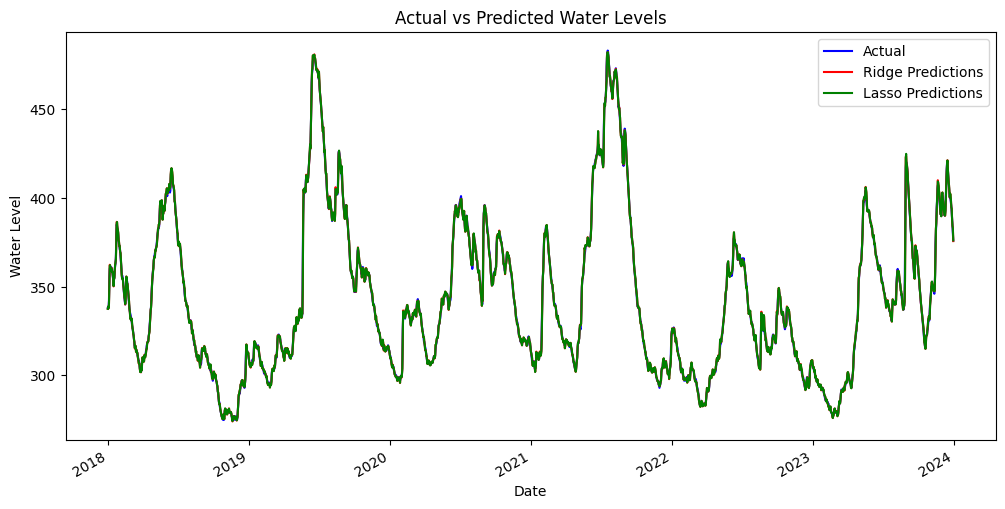

In [25]:
import matplotlib.pyplot as plt

# Convert 'DATE' to datetime
test['DATE'] = pd.to_datetime(test['DATE'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(test['DATE'], y_test_final, label='Actual', color='blue')
plt.plot(test['DATE'], y_pred_ridge_final, label='Ridge Predictions', color='red')
plt.plot(test['DATE'], y_pred_lasso_final, label='Lasso Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Actual vs Predicted Water Levels')
plt.legend()

# Format x-axis dates
plt.gcf().autofmt_xdate()
plt.show()

In [26]:
print(test['DATE'].dtype)
print(y_test_final.min(), y_test_final.max())

datetime64[ns]
275.0000000000001 482.9999999999998


In [27]:
print(test_seasonality['seasonal_value'].min(), test_seasonality['seasonal_value'].max())

-0.140490181118112 0.2249313776978577


In [28]:
# Definition and comparison of metrics
from sklearn.metrics import mean_absolute_error

# Mean Squared Error (MSE)
mse_ridge = mean_squared_error(y_test_final, y_pred_ridge_final)
mse_lasso = mean_squared_error(y_test_final, y_pred_lasso_final)

# Root Mean Squared Error (RMSE)
rmse_ridge = np.sqrt(mse_ridge)
rmse_lasso = np.sqrt(mse_lasso)

# Mean Absolute Error (MAE)
mae_ridge = mean_absolute_error(y_test_final, y_pred_ridge_final)
mae_lasso = mean_absolute_error(y_test_final, y_pred_lasso_final)


In [29]:
print("Model Performance on Test Data:")
print("---------------------------------")
print(f"Ridge Regression:")
print(f"  MSE: {mse_ridge:.4f}")
print(f"  RMSE: {rmse_ridge:.4f}")
print(f"  MAE: {mae_ridge:.4f}\n")

print(f"Lasso Regression:")
print(f"  MSE: {mse_lasso:.4f}")
print(f"  RMSE: {rmse_lasso:.4f}")
print(f"  MAE: {mae_lasso:.4f}")


Model Performance on Test Data:
---------------------------------
Ridge Regression:
  MSE: 1.9610
  RMSE: 1.4004
  MAE: 0.9867

Lasso Regression:
  MSE: 2.0414
  RMSE: 1.4288
  MAE: 0.9968


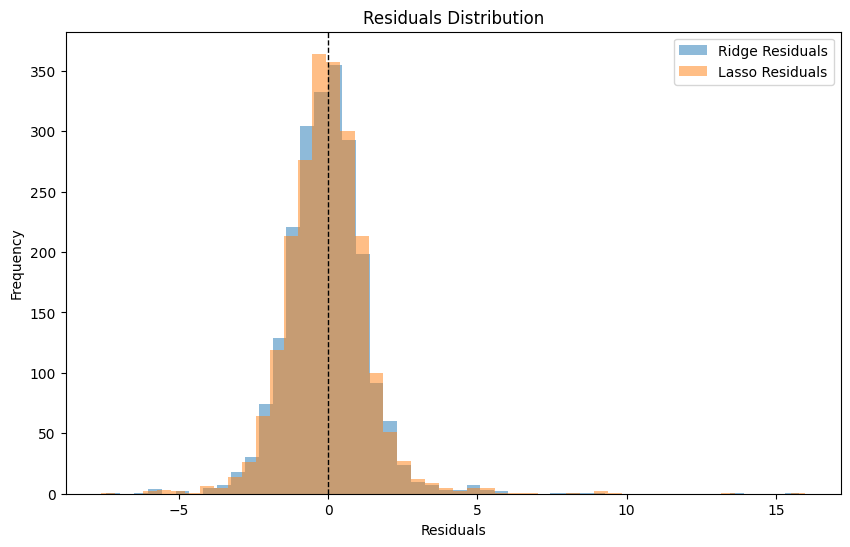

In [30]:
# Calculate and plot residuals

ridge_residuals = y_test_final - y_pred_ridge_final
lasso_residuals = y_test_final - y_pred_lasso_final

plt.figure(figsize=(10, 6))
plt.hist(ridge_residuals, bins=50, alpha=0.5, label="Ridge Residuals")
plt.hist(lasso_residuals, bins=50, alpha=0.5, label="Lasso Residuals")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.show()


In [31]:
metrics_comparison = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE'],
    'Ridge': [mse_ridge, rmse_ridge, mae_ridge],
    'Lasso': [mse_lasso, rmse_lasso, mae_lasso]
})

print(metrics_comparison)

  Metric     Ridge     Lasso
0    MSE  1.960988  2.041435
1   RMSE  1.400353  1.428788
2    MAE  0.986697  0.996817


In [32]:
# Find most predictive feature
test = test.drop(columns=['DATE', 'WATER_LEVEL'])

# Ridge coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': test.columns,
    'Coefficient': best_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Lasso coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': test.columns,
    'Coefficient': best_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Display top features

print("\nTop Features - Ridge Regression")
# Most predictive feature for Ridge
print(ridge_coefficients.head(1))

print("\nTop Features - Lasso Regression")
# Most predictive feature for Lasso
print(lasso_coefficients.head(1))


Top Features - Ridge Regression
              Feature  Coefficient
11  WATER_LEVEL_LAG_1     1.600067

Top Features - Lasso Regression
              Feature  Coefficient
11  WATER_LEVEL_LAG_1     1.494046


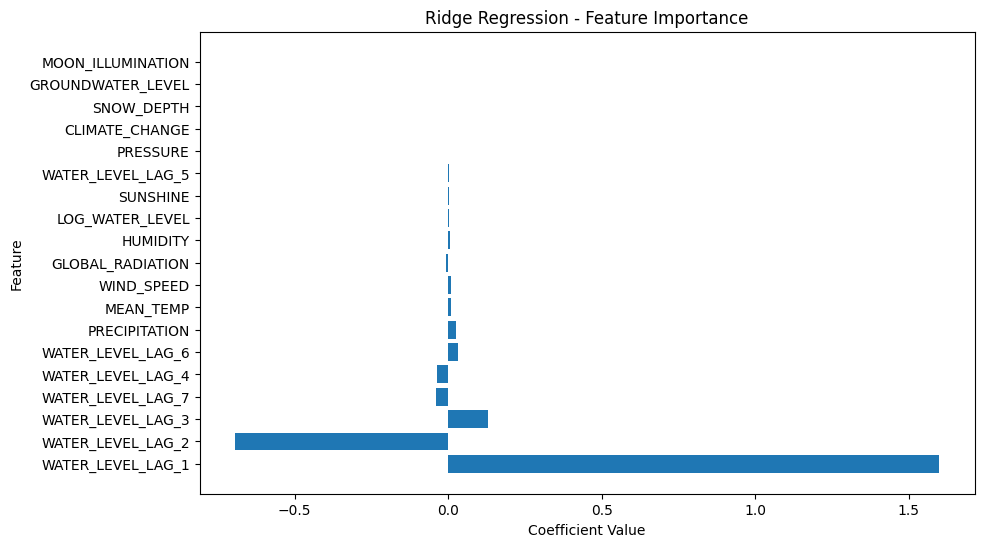

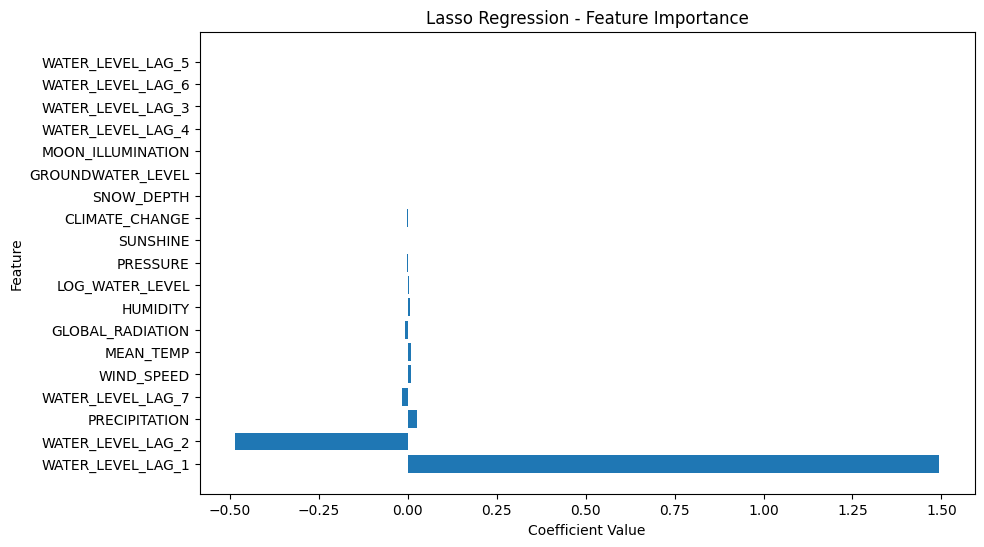

In [33]:
# Plot Ridge feature importance
plt.figure(figsize=(10, 6))
plt.barh(ridge_coefficients['Feature'], ridge_coefficients['Coefficient'])
plt.title('Ridge Regression - Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Plot Lasso feature importance
plt.figure(figsize=(10, 6))
plt.barh(lasso_coefficients['Feature'], lasso_coefficients['Coefficient'])
plt.title('Lasso Regression - Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


In [40]:
#observation: see that most important feature is the water lag 1 -> really depend on the water level of the previous day (more than on external factors)....